In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from scipy import stats

from time import time

/opt/homebrew/Caskroom/miniconda/base/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("sebastianwillmann/beverage-sales")

print("Path to dataset files:", path)

Path to dataset files: /Users/flrlx/.cache/kagglehub/datasets/sebastianwillmann/beverage-sales/versions/1


In [3]:
df = pd.read_csv(path + "/synthetic_beverage_sales_data.csv")

print(df.head())


  Order_ID Customer_ID Customer_Type             Product     Category  \
0     ORD1     CUS1496           B2B          Vio Wasser        Water   
1     ORD1     CUS1496           B2B               Evian        Water   
2     ORD1     CUS1496           B2B              Sprite  Soft Drinks   
3     ORD1     CUS1496           B2B  Rauch Multivitamin       Juices   
4     ORD1     CUS1496           B2B        Gerolsteiner        Water   

   Unit_Price  Quantity  Discount  Total_Price             Region  Order_Date  
0        1.66        53      0.10        79.18  Baden-Württemberg  2023-08-23  
1        1.56        90      0.10       126.36  Baden-Württemberg  2023-08-23  
2        1.17        73      0.05        81.14  Baden-Württemberg  2023-08-23  
3        3.22        59      0.10       170.98  Baden-Württemberg  2023-08-23  
4        0.87        35      0.10        27.40  Baden-Württemberg  2023-08-23  


In [4]:
df.info()

df.describe()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Order_ID       object 
 1   Customer_ID    object 
 2   Customer_Type  object 
 3   Product        object 
 4   Category       object 
 5   Unit_Price     float64
 6   Quantity       int64  
 7   Discount       float64
 8   Total_Price    float64
 9   Region         object 
 10  Order_Date     object 
dtypes: float64(3), int64(1), object(7)
memory usage: 755.3+ MB


Order_ID         0
Customer_ID      0
Customer_Type    0
Product          0
Category         0
Unit_Price       0
Quantity         0
Discount         0
Total_Price      0
Region           0
Order_Date       0
dtype: int64

In [6]:

sns.set_palette("husl")

print("Статистическое описание числовых переменных:")
print(df.describe())


Статистическое описание числовых переменных:
         Unit_Price      Quantity      Discount   Total_Price
count  8.999910e+06  8.999910e+06  8.999910e+06  8.999910e+06
mean   5.818037e+00  2.313813e+01  2.972879e-02  1.307437e+02
std    1.470050e+01  2.689321e+01  4.479841e-02  5.096947e+02
min    3.200000e-01  1.000000e+00  0.000000e+00  3.000000e-01
25%    1.050000e+00  6.000000e+00  0.000000e+00  8.400000e+00
50%    1.750000e+00  1.100000e+01  0.000000e+00  2.114000e+01
75%    3.210000e+00  3.000000e+01  5.000000e-02  6.949000e+01
max    1.695300e+02  1.000000e+02  1.500000e-01  1.429530e+04


In [7]:
print("\nКоличество уникальных значений в категориальных переменных:")
categorical_columns = ['Customer_Type', 'Category', 'Region']
for col in categorical_columns:
    print(f"\n{col}:")
    print(df[col].value_counts().head())
    print(f"Всего уникальных значений: {df[col].nunique()}")



Количество уникальных значений в категориальных переменных:

Customer_Type:
Customer_Type
B2C    5795405
B2B    3204505
Name: count, dtype: int64
Всего уникальных значений: 2

Category:
Category
Alcoholic Beverages    2251625
Water                  2250217
Juices                 2249937
Soft Drinks            2248131
Name: count, dtype: int64
Всего уникальных значений: 4

Region:
Region
Hamburg            604054
Rheinland-Pfalz    577967
Niedersachsen      577005
Saarland           573596
Sachsen            572827
Name: count, dtype: int64
Всего уникальных значений: 16


Существенный дисбаланс между B2B и B2C

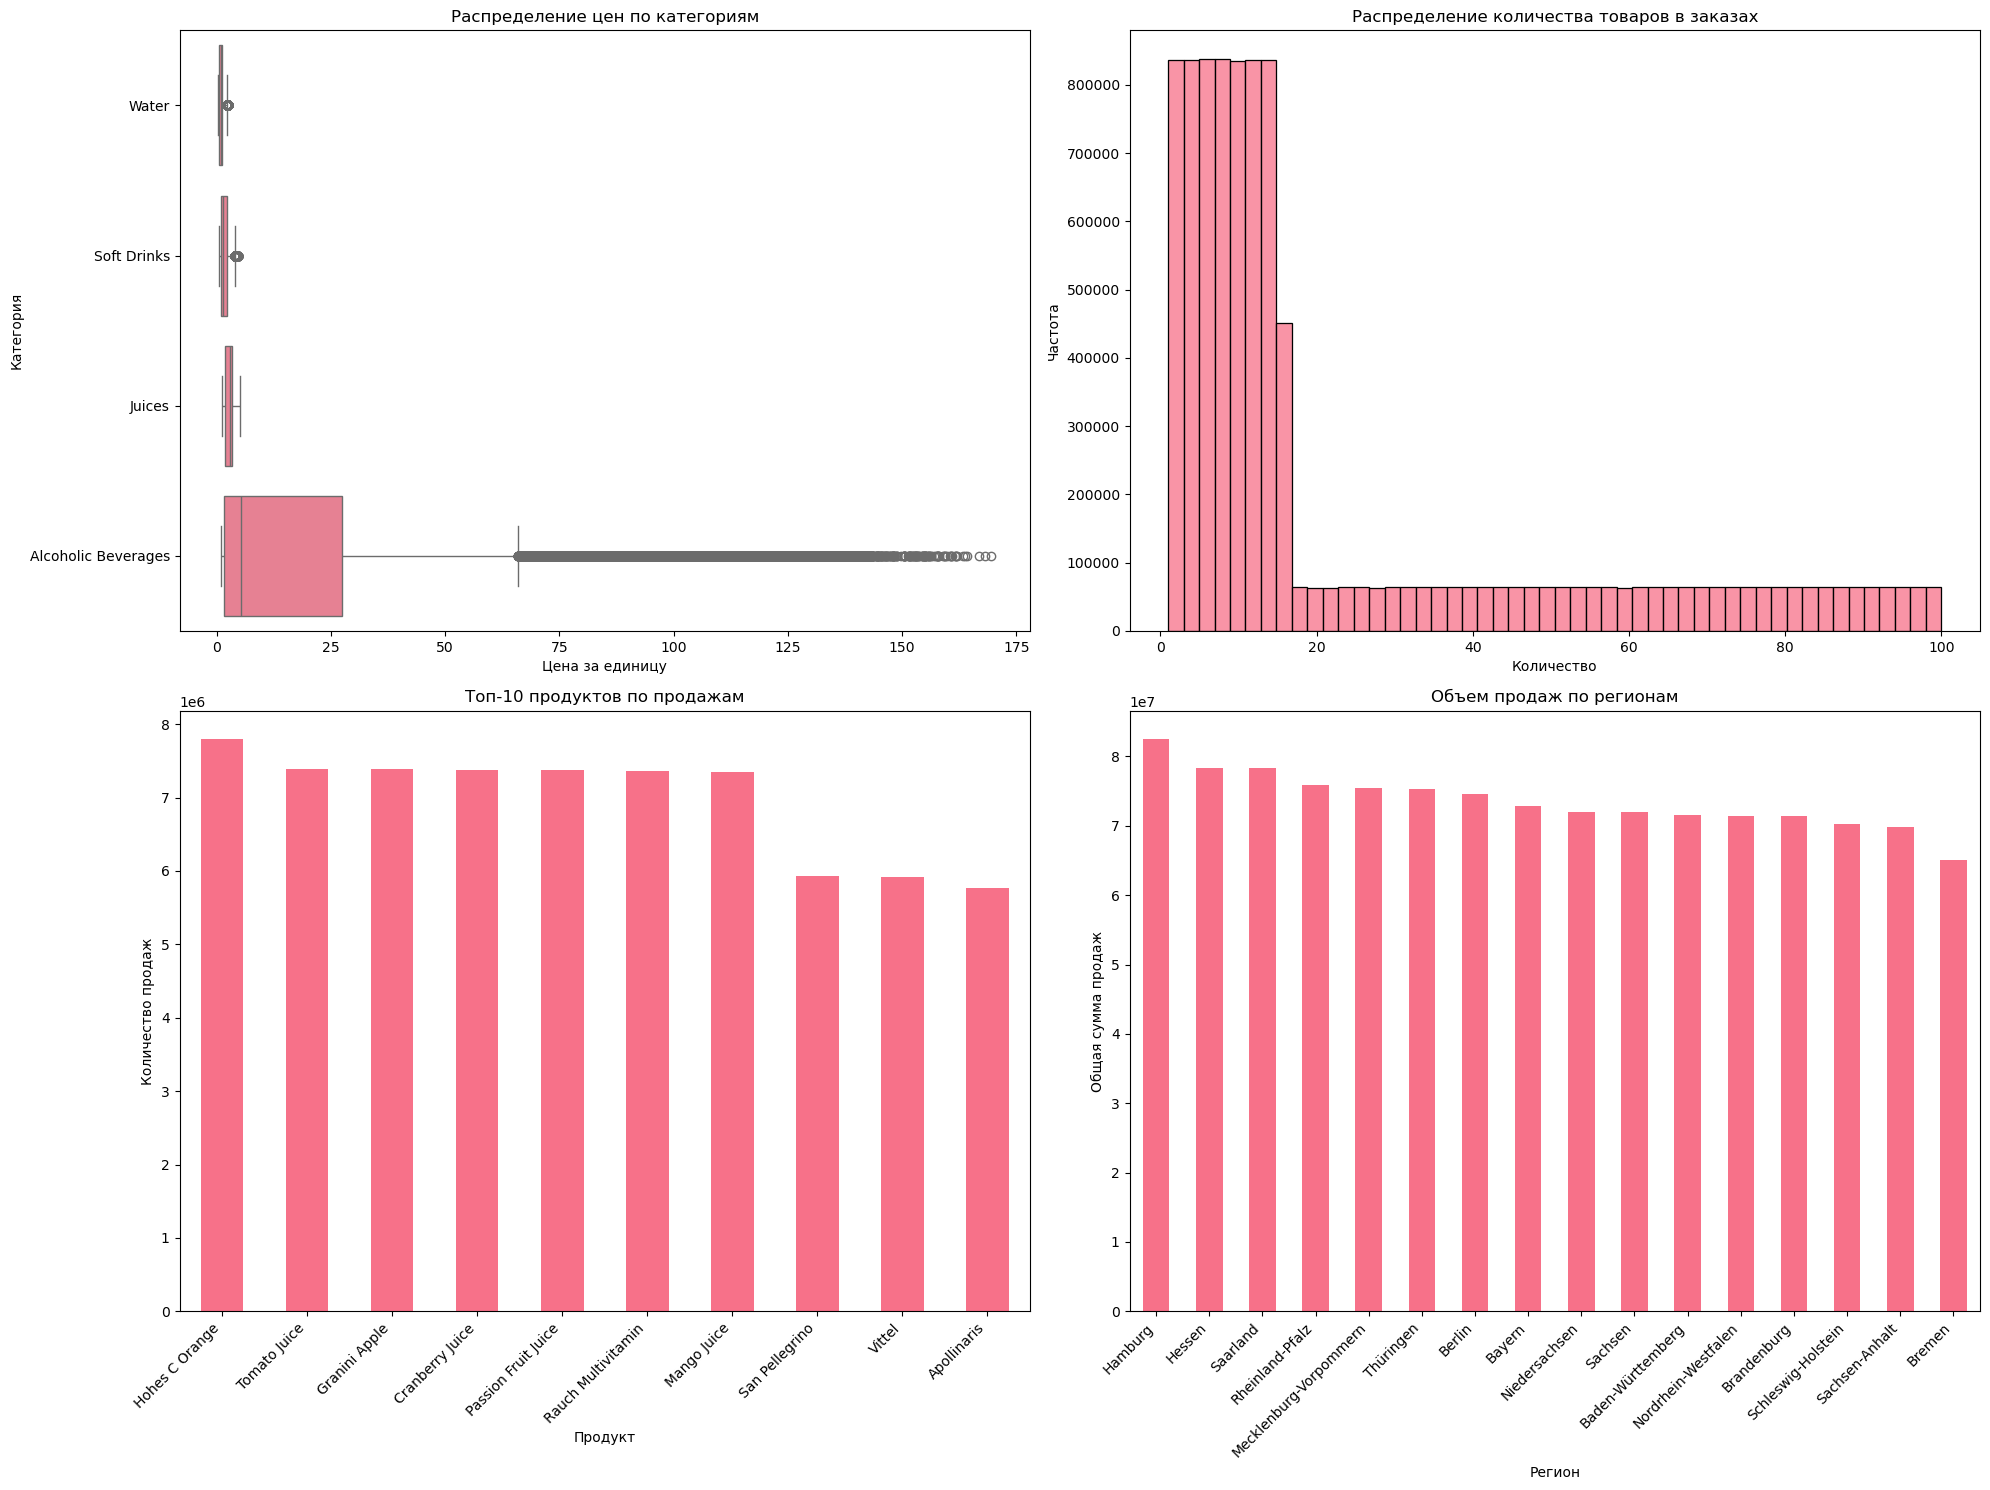

In [8]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, y='Category', x='Unit_Price')
plt.title('Распределение цен по категориям')
plt.xlabel('Цена за единицу')
plt.ylabel('Категория')

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='Quantity', bins=50)
plt.title('Распределение количества товаров в заказах')
plt.xlabel('Количество')
plt.ylabel('Частота')

plt.subplot(2, 2, 3)
top_products = df.groupby('Product')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar')
plt.title('Топ-10 продуктов по продажам')
plt.xlabel('Продукт')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)
region_sales = df.groupby('Region')['Total_Price'].sum().sort_values(ascending=False)
region_sales.plot(kind='bar')
plt.title('Объем продаж по регионам')
plt.xlabel('Регион')
plt.ylabel('Общая сумма продаж')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Неравномерное распределение заказов по регионам

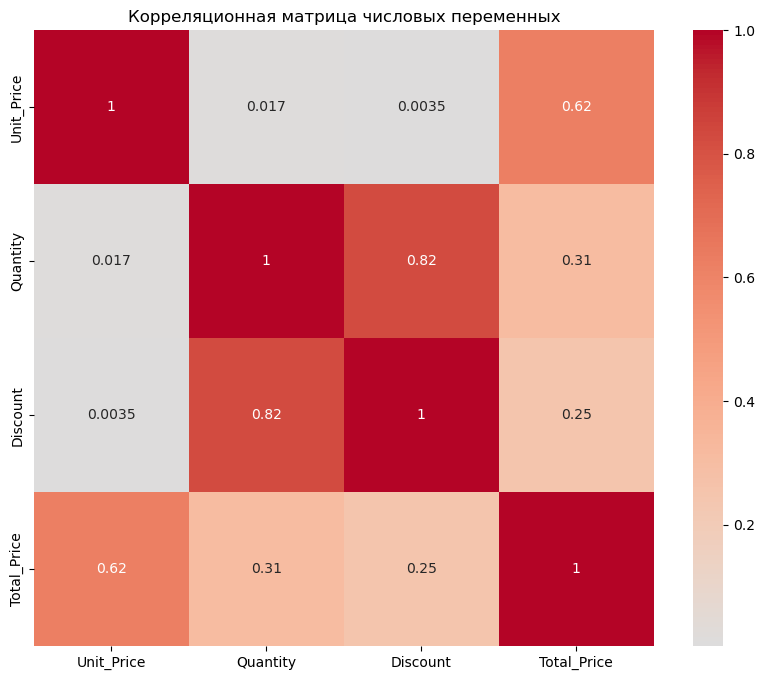

In [9]:
numeric_columns = ['Unit_Price', 'Quantity', 'Discount', 'Total_Price']
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых переменных')
plt.show()


In [10]:
print("\nСтатистика по скидкам:")
print(df['Discount'].describe())
print("\nРаспределение скидок по категориям:")
print(df.groupby('Category')['Discount'].mean().sort_values(ascending=False))


Статистика по скидкам:
count    8.999910e+06
mean     2.972879e-02
std      4.479841e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e-02
max      1.500000e-01
Name: Discount, dtype: float64

Распределение скидок по категориям:
Category
Water                  0.029754
Alcoholic Beverages    0.029729
Soft Drinks            0.029719
Juices                 0.029713
Name: Discount, dtype: float64


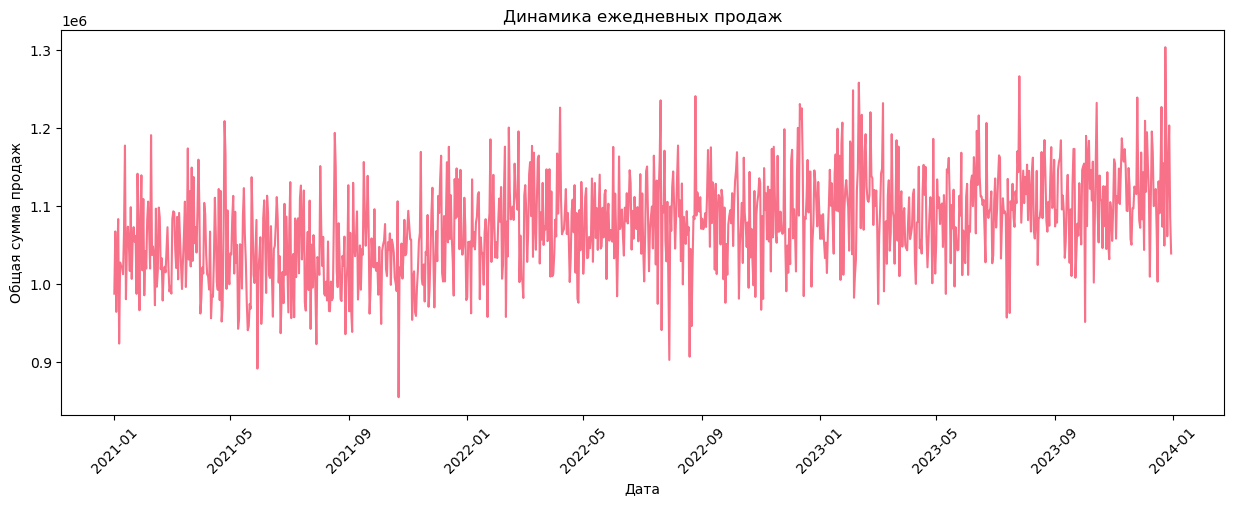

In [11]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
daily_sales = df.groupby('Order_Date')['Total_Price'].sum().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(daily_sales['Order_Date'], daily_sales['Total_Price'])
plt.title('Динамика ежедневных продаж')
plt.xlabel('Дата')
plt.ylabel('Общая сумма продаж')
plt.xticks(rotation=45)
plt.show()

In [12]:
print("\nРаспределение продаж по категориям:")
category_sales = df.groupby('Category')['Total_Price'].agg(['sum', 'mean', 'count']).round(2)
print(category_sales.sort_values('sum', ascending=False))


Распределение продаж по категориям:
                              sum    mean    count
Category                                          
Alcoholic Beverages  9.117979e+08  404.95  2251625
Juices               1.331678e+08   59.19  2249937
Soft Drinks          8.280254e+07   36.83  2248131
Water                4.891285e+07   21.74  2250217


In [13]:
print("\nСтатистика по скидкам:")
discount_stats = df.groupby('Category')['Discount'].agg(['mean', 'std', 'min', 'max']).round(3)
print(discount_stats)


Статистика по скидкам:
                     mean    std  min   max
Category                                   
Alcoholic Beverages  0.03  0.045  0.0  0.15
Juices               0.03  0.045  0.0  0.15
Soft Drinks          0.03  0.045  0.0  0.15
Water                0.03  0.045  0.0  0.15


In [14]:
print("\nСтатистика по ценам по категориям:")
price_stats = df.groupby('Category')['Unit_Price'].agg(['mean', 'std', 'min', 'max']).round(2)
print(price_stats)


Статистика по ценам по категориям:
                      mean    std   min     max
Category                                       
Alcoholic Beverages  18.01  25.74  0.84  169.53
Juices                2.67   0.74  1.05    4.99
Soft Drinks           1.61   0.80  0.53    4.59
Water                 0.97   0.39  0.32    2.50


Огромная разница в ценовых диапазонах между категориями

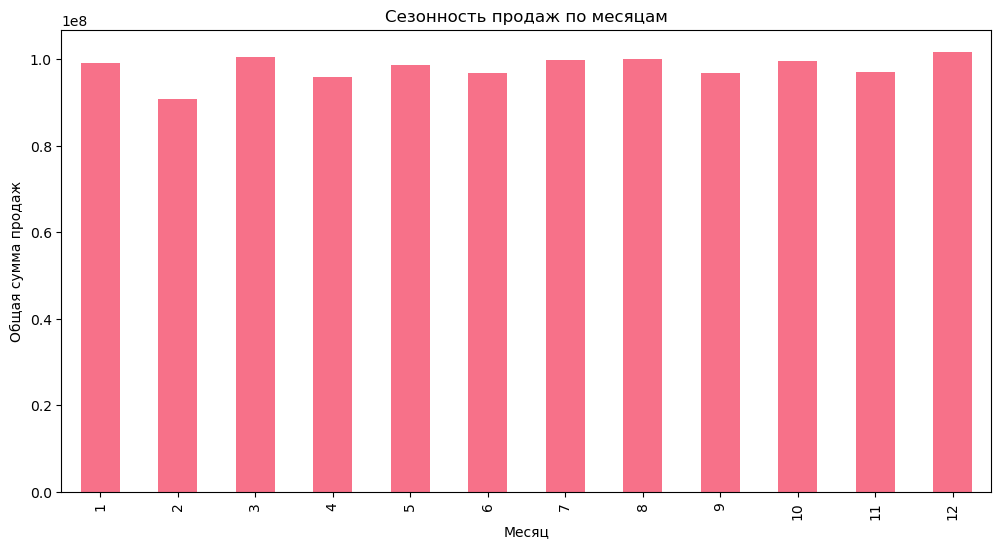

In [15]:
df['Month'] = df['Order_Date'].dt.month
monthly_sales = df.groupby('Month')['Total_Price'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Сезонность продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Общая сумма продаж')
plt.show()

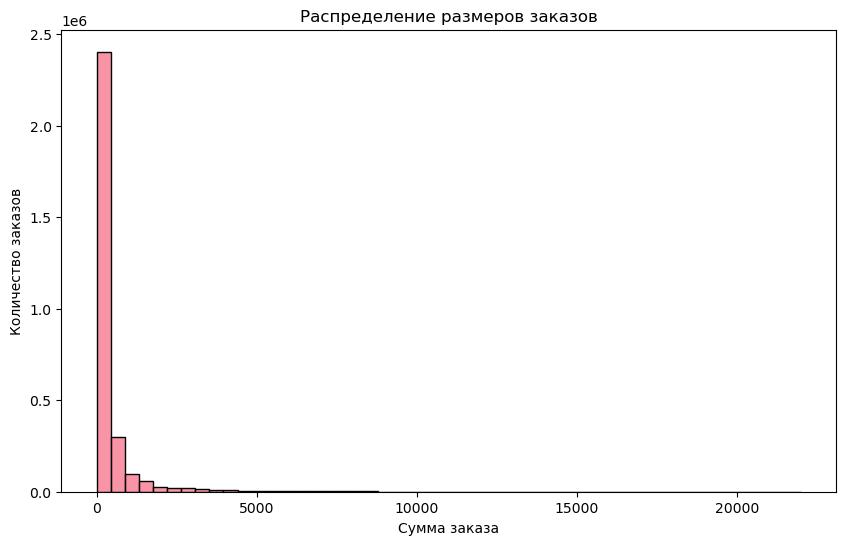

In [16]:
order_sizes = df.groupby('Order_ID')['Total_Price'].sum()

plt.figure(figsize=(10, 6))
sns.histplot(data=order_sizes, bins=50)
plt.title('Распределение размеров заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество заказов')
plt.show()

In [17]:
print("\nПроверка нормальности распределения цен:")
print(stats.normaltest(df['Unit_Price']))

print("\nПроверка нормальности распределения количества:")
print(stats.normaltest(df['Quantity']))


Проверка нормальности распределения цен:
NormaltestResult(statistic=8598871.951539781, pvalue=0.0)

Проверка нормальности распределения количества:
NormaltestResult(statistic=1993825.5633371067, pvalue=0.0)


## Что конкретно можем моделировать?

1. Прогнозирование объема продаж (Total_Price):
    - Целевая переменная: Total_Price
    - Потенциальные предикторы:
        + Unit_Price (средняя цена: 5.82, разброс: 0.32 - 169.53)
        + Quantity (среднее количество: 23.14, разброс: 1 - 100)
        + Discount (средняя скидка: 0.03, разброс: 0 - 0.15)
        + Category (категориальная переменная)
        + Customer_Type (B2B/B2C)
        + Временные признаки (месяц, день недели)
    - Можем использовать регрессионные модели (линейная регрессия, случайный лес, XGBoost)
2. Предсказание количества товаров в заказе (Quantity):
    - Целевая переменная: Quantity
    - Потенциальные предикторы:
        + Unit_Price
        + Category
        + Customer_Type
        + Discount
        + Сезонные факторы
3. Оптимизация скидок:
    - Целевая переменная: Total_Price или Quantity
    - Предикторы:
        + Discount
        + Category
        + Customer_Type
        + Unit_Price
    - Задача: найти оптимальный уровень скидки для максимизации прибыли
    - Можно использовать градиентный бустинг или линейную регрессию с взаимодействием
4. Классификация типов заказов:
    - Целевая переменная: Customer_Type (B2B/B2C)
    - Предикторы:
        + Total_Price
        + Quantity
        + Category
        + Discount
        + Размер заказа
    - Можем использовать случайный лес или логистическую регрессию


## Подготовка данных

In [18]:
print("Размер исходного датасета:", df.shape)

Размер исходного датасета: (8999910, 12)


Распределение скидок в датасете:
Discount
0.00    5795405
0.05    1438899
0.10    1384589
0.15     381017
Name: count, dtype: int64


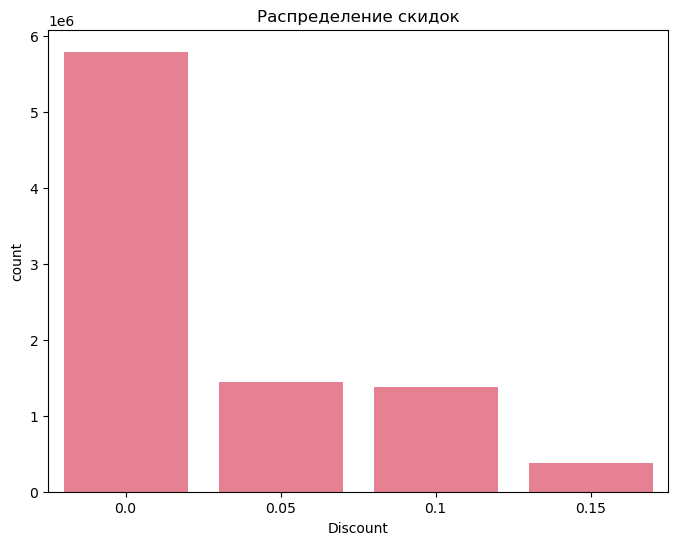

In [19]:
print("Распределение скидок в датасете:")
print(df['Discount'].value_counts().sort_index())
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Discount')
plt.title('Распределение скидок')
plt.show()

Проблема - дисбаланс классов

In [20]:
# Создание новых признаков
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Временные признаки
df['Season'] = df['Order_Date'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})
df['Is_Holiday_Season'] = df['Order_Date'].dt.month.isin([11, 12]).astype(int)
df['Week_Number'] = df['Order_Date'].dt.isocalendar().week

In [21]:
# Признаки по клиентам
customer_order_stats = df.groupby('Customer_ID').agg({
    'Order_ID': 'count',
    'Total_Price': ['mean', 'sum', 'std'],
    'Quantity': ['mean', 'sum', 'std'],
    'Discount': ['mean', 'max']
}).reset_index()

# Переименование столбцов
customer_order_stats.columns = [
    'Customer_ID', 'total_orders', 'avg_order_value', 
    'total_spent', 'order_value_std', 'avg_quantity',
    'total_quantity', 'quantity_std', 'avg_discount', 'max_discount'
]

In [22]:
# Признаки по категориям для каждого клиента
category_pivot = pd.pivot_table(
    df, 
    values='Quantity',
    index='Customer_ID',
    columns='Category',
    aggfunc='sum',
    fill_value=0
)
# Переименование столбцов
category_pivot.columns = [f'quantity_in_{col.lower().replace(" ", "_")}' for col in category_pivot.columns]

In [23]:
# Объединение признаков
df = df.merge(customer_order_stats, on='Customer_ID', how='left')
df = df.merge(category_pivot, on='Customer_ID', how='left')

In [24]:
# Признаки взаимодействия
df['Price_Quantity_Ratio'] = df['Total_Price'] / df['Quantity']
df['Order_Size_vs_Average'] = df['Total_Price'] / df['avg_order_value']
df['Quantity_vs_Average'] = df['Quantity'] / df['avg_quantity']


In [25]:
# Кодирование категориальных признаков
le_dict = {}
categorical_columns = ['Category', 'Customer_Type', 'Season']
for col in categorical_columns:
    le_dict[col] = LabelEncoder()
    df[f'{col}_encoded'] = le_dict[col].fit_transform(df[col])


In [26]:
features = [
    # Основные характеристики заказа
    'Unit_Price', 'Quantity', 'Total_Price',
    'Category_encoded', 'Customer_Type_encoded',
    
    # Клиентские метрики
    'total_orders', 'avg_order_value', 'total_spent',
    'order_value_std', 'avg_quantity', 'total_quantity',
    'quantity_std', 'avg_discount', 'max_discount',
    
    # Временные признаки
    'Season_encoded', 'Is_Holiday_Season', 'Week_Number',
    
    # Признаки взаимодействия
    'Price_Quantity_Ratio', 'Order_Size_vs_Average',
    'Quantity_vs_Average'
]

features.extend(category_pivot.columns.tolist())

In [27]:
# Кодирование целевой переменной
X = df[features]
y = df['Discount'].map({0.0: 0, 0.05: 1, 0.1: 2, 0.15: 3})

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
# RobustScaler для уменьшения влияния выбросов (так как использует межквартильный размах и медиану)
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

# Применяем PowerTransformer для приведения распределения ближе к нормальному
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_scaled = power_transformer.fit_transform(X_train_scaled)
X_test_scaled = power_transformer.transform(X_test_scaled)

In [16]:
xgb_model = xgb.XGBClassifier(
    learning_rate=0.05, # скорость обучения
    max_depth=8, # максимальная глубина дерева
    n_estimators=200, # количество деревьев
    subsample=0.8, # доля случайных подмножеств для обучения каждого дерева
    colsample_bytree=0.8, # доля признаков для обучения каждого дерева
    random_state=777 # для воспроизводимости
)

rf_model = RandomForestClassifier(
    n_estimators=200, # количество деревьев
    max_depth=10, # максимальная глубина дерева
    min_samples_split=5, # минимальное количество образцов для разделения узла
    random_state=777 # для воспроизводимости
)

lr_model = LogisticRegression(
    solver='sag',  # Используем SAG solver, который лучше работает с большими датасетами
    C=0.1,        # Увеличиваем регуляризацию
    random_state=777, # для воспроизводимости
    n_jobs=-1     # Используем все доступные ядра
)

XGBoost (градиентный бустинг) настроен с умеренной скоростью обучения (0.05) и глубиной деревьев (8), что позволяет модели находить сложные нелинейные зависимости, при этом избегая переобучения благодаря параметрам подвыборки (subsample и colsample_bytree = 0.8). Random Forest с 200 деревьями и глубиной 10 обеспечивает стабильность предсказаний и хорошо работает с категориальными признаками, а минимальное количество образцов для разделения (min_samples_split=5) помогает контролировать сложность модели. Логистическая регрессия с solver='sag' и повышенной регуляризацией (C=0.1) добавляет линейную составляющую в ансамбль и обеспечивает базовую интерпретируемость результатов.


In [17]:
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    weights=[2, 2, 1],  # Даем меньший вес логистической регрессии
    voting='soft' # метод голосования
)

Объединяем эти модели в ансамбль, используя VotingClassifier с "мягким" голосованием (voting='soft'), что позволяет учитывать вероятности предсказаний каждой модели, а не только их окончательные решения. Веса моделей [2, 2, 1] отражают наше доверие к их предсказаниям: XGBoost и Random Forest получают больший вес из-за их способности улавливать нелинейные паттерны в данных, в то время как логистическая регрессия, будучи более простой моделью, получает меньший вес. Такая комбинация позволяет получить более робастные предсказания, используя сильные стороны каждой модели и компенсируя их недостатки.

In [ ]:
print("Обучение ансамбля моделей...")
ensemble.fit(X_train_scaled, y_train)

Обучение ансамбля моделей...


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.1, n_jobs=-1,
                                                 random_state=42,
                                                 solver='sag'))],
                 voting='soft', weights=[2, 2, 1])

In [ ]:
y_pred = ensemble.predict(X_test_scaled)

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred,
                          target_names=['0%', '5%', '10%', '15%']))



Отчет о классификации:
              precision    recall  f1-score   support

          0%       1.00      1.00      1.00   1159081
          5%       0.89      0.94      0.92    287780
         10%       0.86      0.91      0.89    276918
         15%       1.00      0.61      0.76     76203

    accuracy                           0.96   1799982
   macro avg       0.94      0.86      0.89   1799982
weighted avg       0.96      0.96      0.96   1799982



 Модель демонстрирует почти идеальную точность (precision=1.00) и полноту (recall=1.00) для случаев без скидки (0%), что логично, учитывая преобладание таких случаев в данных (около 64% от всех наблюдений). Для средних значений скидок (5% и 10%) модель показывает хорошие, но немного более низкие показатели (f1-score около 0.90), что указывает на некоторые трудности в различении этих категорий. Интересно отметить особенность работы с максимальными скидками (15%): несмотря на отличную точность (precision=1.00), модель имеет относительно низкую полноту (recall=0.61), что говорит о том, что она склонна пропускать случаи максимальных скидок, но когда предсказывает их, то делает это очень точно. Общая точность модели 0.96 является отличным показателем, учитывая несбалансированность классов и сложность задачи предсказания скидок.

Можно рассмотреть применение техник балансировки классов или настройку порогов принятия решений, но текущие результаты уже достаточно высоки для практического применения. Взвешенные метрики совпадают с общей точностью, что подтверждает хорошую работу модели даже с учетом несбалансированности классов.


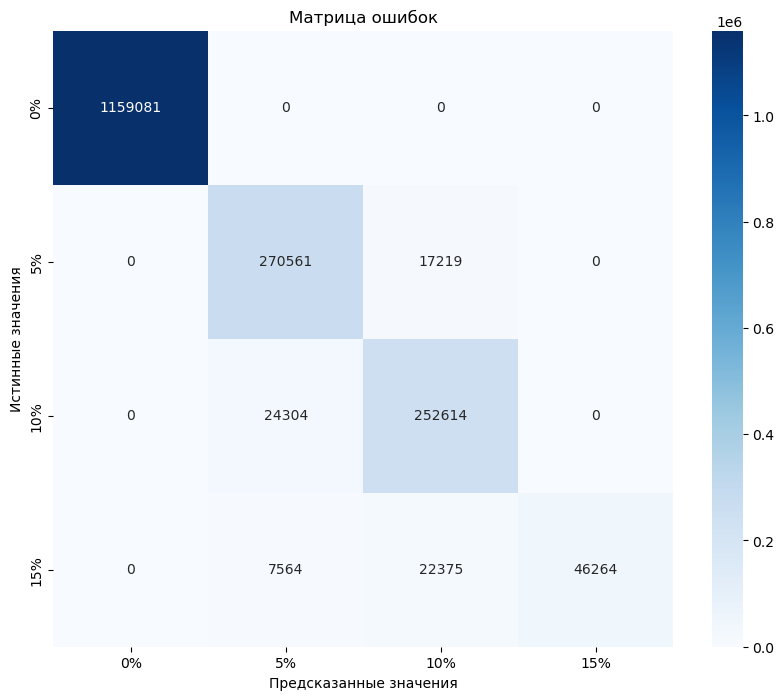

In [ ]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0%', '5%', '10%', '15%'],
            yticklabels=['0%', '5%', '10%', '15%'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()


Время выполнения на выборке 1000000 записей: 429.55 секунд


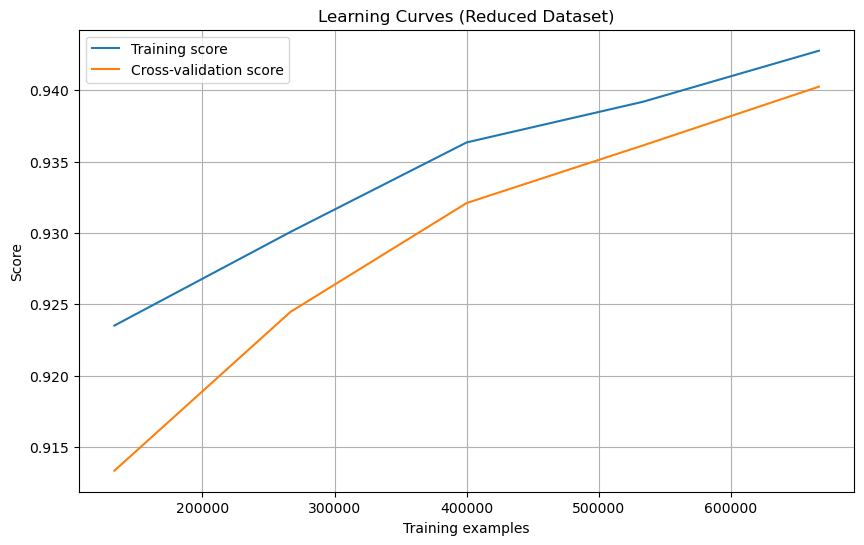


Результаты:
Тренировочная выборка:
Средняя точность: 0.9428 (+/- 0.0011)

Валидационная выборка:
Средняя точность: 0.9403 (+/- 0.0016)

Разница между train и validation: 0.0025
Модель хорошо сбалансирована (разница в пределах 5%)


In [ ]:
# Размер тестовой выборки
sample_size = 1000000

# выборка с сохранением связи между X и y
indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[indices]
y_sample = np.array(y_train)[indices]  # Преобразуем в numpy array

start_time = time()

# Строим кривую обучения на тестовой выборке
train_sizes, train_scores, val_scores = learning_curve(
    ensemble,
    X_sample, 
    y_sample,
    train_sizes=np.linspace(0.2, 1.0, 5),
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

end_time = time()
print(f"\nВремя выполнения на выборке {sample_size} записей: {end_time - start_time:.2f} секунд")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves (Reduced Dataset)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Выводим средние значения и стандартные отклонения
print("\nРезультаты:")
print("Тренировочная выборка:")
print(f"Средняя точность: {np.mean(train_scores[-1]):.4f} (+/- {np.std(train_scores[-1])*2:.4f})")
print("\nВалидационная выборка:")
print(f"Средняя точность: {np.mean(val_scores[-1]):.4f} (+/- {np.std(val_scores[-1])*2:.4f})")

# Разница между тренировочной и валидационной точностью
diff = np.mean(train_scores[-1]) - np.mean(val_scores[-1])
print(f"\nРазница между train и validation: {diff:.4f}")

if diff > 0.05:
    print("Возможно переобучение (разница > 5%)")
elif diff < -0.05:
    print("Возможное недообучение (разница < -5%)")
else:
    print("Модель хорошо сбалансирована (разница в пределах 5%)")

In [ ]:
def recommend_discount(model, scaler, customer_data):
    """
    Функция для рекомендации скидки конкретному клиенту
    """
    customer_scaled = scaler.transform(customer_data)
    probabilities = model.predict_proba(customer_scaled)
    
    discount_values = [0.0, 0.05, 0.10, 0.15]
    discount_probs = dict(zip(discount_values, probabilities[0]))
    
    print("\nВероятности для каждой скидки:")
    for discount, prob in discount_probs.items():
        print(f"Скидка {discount*100}%: {prob:.2%}")
    
    predicted_class = model.predict(customer_scaled)[0]
    return discount_values[predicted_class]

# Пример использования
example_customer = X_test.iloc[0:1]
print("\nПример рекомендации скидки для клиента:")
recommended_discount = recommend_discount(ensemble, scaler, example_customer)
print(f"Рекомендуемая скидка: {recommended_discount*100}%")


Пример рекомендации скидки для клиента:

Вероятности для каждой скидки:
Скидка 0.0%: 100.00%
Скидка 5.0%: 0.00%
Скидка 10.0%: 0.00%
Скидка 15.0%: 0.00%
Рекомендуемая скидка: 0.0%


## Польза для бизнеса

### Применения:
1. Персонализация скидок:
- Для B2B клиентов: анализ объема закупок и регулярности заказов
- Для B2C клиентов: учет истории покупок и предпочтений по категориям
- Дифференциация скидок по регионам и сезонам
2. Оптимизация прибыли через расчет потенциальной прибыли для разных сценариев скидок
- Баланс между размером скидки и объемом продаж
- Учет маржинальности разных категорий товаров
- Прогнозирование изменения спроса при разных уровнях скидок

### Ключевые бизнес-метрики для контроля:

Финансовые показатели:

In [ ]:
# Изменение выручки
revenue_change = (new_revenue - baseline_revenue) / baseline_revenue * 100

# Изменение прибыли
profit_change = (new_profit - baseline_profit) / baseline_profit * 100

# ROI от скидок
discount_roi = (incremental_profit) / (discount_cost) * 100

Операционные метрики:
- Конверсия предложенных скидок
- Средний размер заказа
- Частота повторных покупок
- Процент возврата товаров

Контрольные метрики модели:

In [ ]:
# Точность рекомендаций
accuracy = correct_recommendations / total_recommendations

# Экономическая эффективность
economic_efficiency = additional_profit / discount_value

# Процент принятия рекомендаций
acceptance_rate = accepted_recommendations / total_recommendations

### Система мониторинга

1. Ежедневный контроль:
- Объем продаж с рекомендованными скидками
- Процент принятия рекомендаций
- Средний чек
2. Еженедельный анализ:
- Изменение поведения клиентов
- Эффективность по категориям товаров
- Региональные различия
3. Ежемесячная оценка:
- ROI программы скидок
- Влияние на лояльность клиентов
- Необходимость переобучения модели